In [ ]:
from google.colab import files
uploadFolder = files.upload()


Saving Satellite Image Classification.zip to Satellite Image Classification.zip


In [ ]:
import zipfile
import os

datasetZip = "Satellite Image Classification.zip"
extractFolder = "/content/Satellite Image Classification"

with zipfile.ZipFile(datasetZip, 'r') as zip_ref:
  zip_ref.extractall(extractFolder)

print("Dataset Extracted Succesfully")

Dataset Extracted Succesfully


In [ ]:
satelliteDatasetPath = "/content/Satellite Image Classification/data"

In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from collections import Counter
import os

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2, InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [8]:
satelliteImgHeight = 64
satelliteImgWidth = 64

In [9]:
rawTrainData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                 subset = "training",
                                                                 seed = 42,
                                                                 image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                 label_mode = "categorical",
                                                                 validation_split = 0.20,
                                                                 batch_size = 64
                                                                )
rawValidationData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                   subset = "validation",
                                                                   seed = 42,
                                                                   image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                   label_mode = "categorical",
                                                                   validation_split = 0.20,
                                                                   batch_size = 64
                                                                  )

AUTOTUNE = tf.data.AUTOTUNE

satelliteTrainingData = rawTrainData.cache().shuffle(1000).prefetch(AUTOTUNE)

satelliteValidationData = keras.utils.image_dataset_from_directory(satelliteDatasetPath,
                                                                   subset = "validation",
                                                                   seed = 42,
                                                                   image_size = (satelliteImgHeight, satelliteImgWidth),
                                                                   label_mode = "categorical",
                                                                   validation_split = 0.20,
                                                                   batch_size = 64
                                                                  ).cache().prefetch(AUTOTUNE)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [10]:
dataAugmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.2)
])

satelliteTrainAugmented = satelliteTrainingData.map(lambda i, j: (dataAugmentation(i), j))
# satelliteTrainAugmented

In [11]:
satelliteNormalizationLayer = tf.keras.layers.Rescaling(1./255)

satelliteTrainNorm = satelliteTrainAugmented.map(lambda i, j: (satelliteNormalizationLayer(i), j))
satelliteValidationNorm = satelliteValidationData.map(lambda i, j: (satelliteNormalizationLayer(i), j))

In [12]:
classNames = rawTrainData.class_names
classNames

['cloudy', 'desert', 'green_area', 'water']

In [13]:
labels = []
for _, label in satelliteTrainNorm:
    # Convert one-hot to class index
    labels.extend(np.argmax(label.numpy(), axis = 1))

# Count Occurrences of each class
labelCounts = Counter(labels)
print(labelCounts)

# Print class-wise count
for ind, count in labelCounts.items():
    print(f"{classNames[ind]}: {count}")

Counter({0: 1233, 3: 1183, 2: 1182, 1: 907})
green_area: 1182
water: 1183
desert: 907
cloudy: 1233


In [14]:
classWeights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(labels),
    y = labels
)

classWeightDict = {i : classWeights[i] for i in range(len(classWeights))}
print(f"Computed Class Weights: {classWeightDict}")

Computed Class Weights: {0: 0.9134225466342255, 1: 1.2417309812568909, 2: 0.952834179357022, 3: 0.952028740490279}


In [15]:
autotune = tf.data.AUTOTUNE

satelliteTrainPrefetch = satelliteTrainNorm.prefetch(buffer_size = autotune).shuffle(buffer_size = 64)
satelliteValidationPrefetch = satelliteValidationNorm.prefetch(buffer_size = autotune)

In [17]:
baseModel = ResNet50V2(weights = 'imagenet', include_top = False, input_shape = (satelliteImgHeight, satelliteImgWidth, 3))

In [22]:
for layer in baseModel.layers:
  layer.trainable = False

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = "relu")(x)

num_classes = len(rawTrainData.class_names)
predictions = Dense(num_classes, activation = "softmax")(x)

cnnModel = Model(inputs = baseModel.input, outputs = predictions)

In [23]:
cnnModel.compile(optimizer = Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [24]:
modelHistory = cnnModel.fit(
    satelliteTrainPrefetch,
    validation_data = satelliteValidationPrefetch,
    epochs = 15,
    class_weight = classWeightDict
)

Epoch 1/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8636 - loss: 0.3289 - val_accuracy: 0.9742 - val_loss: 0.0907
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9687 - loss: 0.0887 - val_accuracy: 0.9840 - val_loss: 0.0733
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9738 - loss: 0.0802 - val_accuracy: 0.9627 - val_loss: 0.1057
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9742 - loss: 0.0838 - val_accuracy: 0.9512 - val_loss: 0.1480
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9742 - loss: 0.0669 - val_accuracy: 0.9760 - val_loss: 0.0724
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9662 - loss: 0.0854 - val_accuracy: 0.9556 - val_loss: 0.1265
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9748 - loss: 0.0801 - val_accuracy: 0.9618 - val_loss: 0.1061
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.9747 - loss: 0.0741 - val_accuracy: 0.9760 - va

In [26]:
cnnModel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 16, 16, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 16, 16, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 18, 18, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 29,871,630 (113.95 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 4,204,554 (16.04 MB)

In [35]:
validationLoss, validationAccuracy = cnnModel.evaluate(satelliteValidationPrefetch)
print(f"Validation Loss: {validationLoss:.2%}")
print(f"Validation Accuracy: {validationAccuracy:.2%}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 845ms/step - accuracy: 0.9827 - loss: 0.0469
Validation Loss: 6.31%
Validation Accuracy: 97.87%


In [30]:
trueLabels = []
predictedLabels = []

for images, labels in satelliteValidationPrefetch:
    pred = cnnModel.predict(images)
    predictedLabels.extend(np.argmax(pred, axis = 1))
    trueLabels.extend(np.argmax(labels.numpy(), axis = 1))

confusionMatrix = confusion_matrix(trueLabels, predictedLabels)
print(confusionMatrix)

fig = px.imshow(confusionMatrix,
                labels = dict(x = "Predicted", y = "Actual", color = "Count"),
                x = rawTrainData.class_names,
                y = rawTrainData.class_names,
                text_auto = True,
                title = "Confusion Matrix"
               )
fig.update_layout(width = 500, height = 400)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[267   0   0   0]
 [  0 223   1   0]
 [  0   0 314   4]
 [  0   0  19 298]]


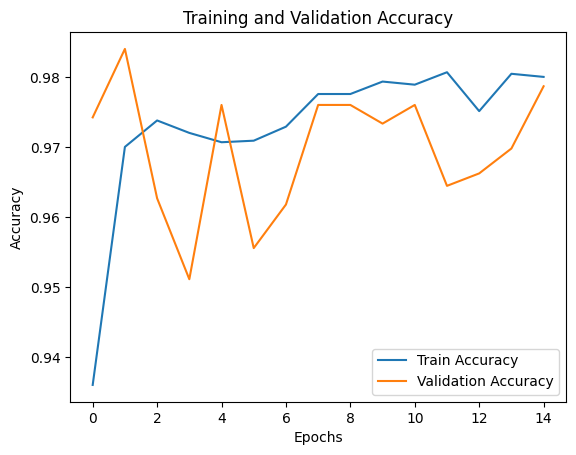

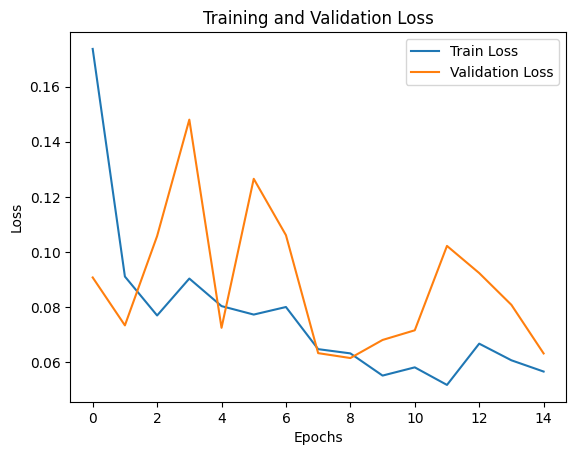

In [31]:
# Accuracy
plt.plot(modelHistory.history['accuracy'], label = "Train Accuracy")
plt.plot(modelHistory.history['val_accuracy'], label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()


# Loss
plt.plot(modelHistory.history["loss"], label = "Train Loss")
plt.plot(modelHistory.history['val_loss'], label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [32]:
from PIL import Image

In [89]:
# img_path = "/content/Satellite Image Classification/data/cloudy/train_1060.jpg"
# img_path = "/content/Satellite Image Classification/data/desert/desert(37).jpg"
# img_path = "/content/Satellite Image Classification/data/green_area/Forest_89.jpg"
img_path = "/content/Satellite Image Classification/data/water/SeaLake_1011.jpg"

In [90]:
img = Image.open(img_path)

print(img.mode)

if img.mode == "CMYK":
    img = img.convert("RGB")

print(img.mode)

img = img.resize((128, 128))

img_array = np.array(img) / 255.0
print(img_array.shape)

img_array = np.expand_dims(img_array, axis = 0)
print(img_array.shape)

RGB
RGB
(128, 128, 3)
(1, 128, 128, 3)


In [91]:
prediction = cnnModel.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


In [92]:
predictedClass = np.argmax(prediction)
predictedClass

3

In [93]:
classLabels = rawTrainData.class_names
classLabels

['cloudy', 'desert', 'green_area', 'water']

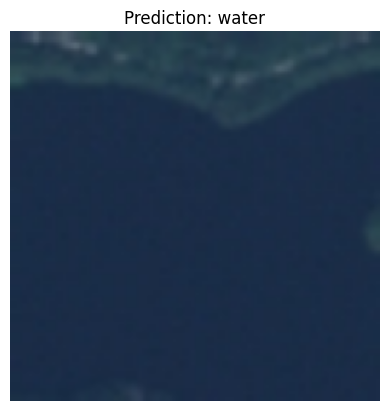

In [94]:
plt.imshow(img)
plt.title(f"Prediction: {classLabels[predictedClass]}")
plt.axis("off")
plt.show()